# Survival Analysis in Glioma from Selected Features

This is a very rough exploration of survival biomarkers obtained from the selected features from the Glioma classifier evaluation. Using Cox regression on individual biomarkers and Kaplan-Meier analysis, the aim is to obtain biomarkers that are linked to disease progression.

In [58]:
!conda env create -f environment.yml
!pip install ipykernel
!pip install lifelines
!python -m ipykernel install --user --name JupyterLab --display-name "Python (JupyterLab)"


EnvironmentFileNotFound: '/home/kbanerj1/TCGA_ML/environment.yml' file not found

Installed kernelspec JupyterLab in /home/kbanerj1/.local/share/jupyter/kernels/jupyterlab


In [59]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read the datasets

In [60]:
os.chdir("/home/kbanerj1/TCGA_ML")
# Verify the current directory
print("Current Directory:", os.getcwd())

Current Directory: /home/kbanerj1/TCGA_ML


In [61]:
# load the dataset
extraction_dir = "./processed"
data_path = os.path.join(extraction_dir, 'selected_feature_data.csv')
labels_path = os.path.join(extraction_dir, 'glioma_labels.csv')
data_df = pd.read_csv(data_path)
labels_df = pd.read_csv(labels_path)

print("Gene Expression Data Shape:\n", data_df.shape)
print("\nLabels Head:\n", labels_df.shape)

Gene Expression Data Shape:
 (575, 201)

Labels Head:
 (575, 2)


In [62]:
# Load clinical data 
clinical_data = pd.read_csv("./metadata/clinical.tsv", sep='\t')
clinical_data.head()

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
0,d420e653-3fb2-432b-9e81-81232a80264d,HCM-BROD-0210-C71,HCMI-CMDC,'--,False,Cancer Related,'--,'--,-19586,481,...,'--,'--,'--,'--,'--,'--,Adjuvant,no,'--,Immunotherapy (Including Vaccines)
1,d420e653-3fb2-432b-9e81-81232a80264d,HCM-BROD-0210-C71,HCMI-CMDC,'--,False,Cancer Related,'--,'--,-19586,481,...,'--,'--,'--,'--,'--,'--,Adjuvant,no,'--,Targeted Molecular Therapy
2,d420e653-3fb2-432b-9e81-81232a80264d,HCM-BROD-0210-C71,HCMI-CMDC,'--,False,Cancer Related,'--,'--,-19586,481,...,'--,'--,'--,'--,'--,'--,Adjuvant,no,'--,"Radiation Therapy, NOS"
3,d420e653-3fb2-432b-9e81-81232a80264d,HCM-BROD-0210-C71,HCMI-CMDC,'--,False,Cancer Related,'--,'--,-19586,481,...,'--,'--,'--,'--,'--,'--,Adjuvant,yes,'--,Chemotherapy
4,d420e653-3fb2-432b-9e81-81232a80264d,HCM-BROD-0210-C71,HCMI-CMDC,'--,False,Cancer Related,'--,'--,-19586,481,...,'--,'--,'--,'--,'--,'--,Neoadjuvant,no,'--,'--


In [63]:
clinical_data.shape

(1386, 158)

In [64]:
# drop duplicates based on 'case_submitter_id'
clinical_data_dedup = clinical_data.drop_duplicates(subset='case_submitter_id', keep='first')
clinical_data_dedup.shape

(663, 158)

In [85]:
labels_df = labels_df.rename(columns={"Sample ID": "sample", "label":"cancer_type"})
labels_df.head()

,sample,cancer_type
0,C3L-03748-04,Glioblastoma
1,HCM-BROD-0106-C71-02A,Glioblastoma
2,HCM-BROD-0106-C71-85A,Glioblastoma
3,HCM-BROD-0103-C71-85B,Glioblastoma
4,HCM-BROD-0210-C71-02A,Glioblastoma


### Create survival dataframe

In [65]:
# check to identify potential time-to-event or survival-related columns
clinical_data_dedup.columns.tolist()

['case_id',
 'case_submitter_id',
 'project_id',
 'age_at_index',
 'age_is_obfuscated',
 'cause_of_death',
 'cause_of_death_source',
 'country_of_residence_at_enrollment',
 'days_to_birth',
 'days_to_death',
 'ethnicity',
 'gender',
 'occupation_duration_years',
 'premature_at_birth',
 'race',
 'vital_status',
 'weeks_gestation_at_birth',
 'year_of_birth',
 'year_of_death',
 'adrenal_hormone',
 'age_at_diagnosis',
 'ajcc_clinical_m',
 'ajcc_clinical_n',
 'ajcc_clinical_stage',
 'ajcc_clinical_t',
 'ajcc_pathologic_m',
 'ajcc_pathologic_n',
 'ajcc_pathologic_stage',
 'ajcc_pathologic_t',
 'ajcc_staging_system_edition',
 'anaplasia_present',
 'anaplasia_present_type',
 'ann_arbor_b_symptoms',
 'ann_arbor_b_symptoms_described',
 'ann_arbor_clinical_stage',
 'ann_arbor_extranodal_involvement',
 'ann_arbor_pathologic_stage',
 'best_overall_response',
 'breslow_thickness',
 'burkitt_lymphoma_clinical_variant',
 'child_pugh_classification',
 'circumferential_resection_margin',
 'classificatio

Here, 'case_submitter_id', 'days_to_death', 'days_to_last_follow_up', 'vital_status' seem appropriate.

In [66]:
survival_df = clinical_data_dedup[['case_submitter_id', 'days_to_death', 'days_to_last_follow_up', 'vital_status']].copy()

In [67]:
vital_status_distribution = survival_df['vital_status'].value_counts()
vital_status_distribution

vital_status
Alive           385
Dead            274
Not Reported      3
Unknown           1
Name: count, dtype: int64

Dropping the 'Not Reported' and 'Unknown' labels

In [68]:
# remove rows where 'vital_status' is 'Not Reported' or 'Unknown'
survival_df = survival_df[~survival_df['vital_status'].isin(['Not Reported', 'Unknown'])]
# create the 'event' column (1 = Dead, 0 = Alive)
survival_df['event'] = survival_df['vital_status'].apply(lambda x: 1 if x == 'Dead' else 0)

# 'days_to_death' is missing, use 'days_to_last_follow_up' as the time
survival_df['days_to_death'] = pd.to_numeric(survival_df['days_to_death'], errors='coerce')
survival_df['days_to_last_follow_up'] = pd.to_numeric(survival_df['days_to_last_follow_up'], errors='coerce')
survival_df['time'] = survival_df['days_to_death'].fillna(survival_df['days_to_last_follow_up'])
survival_df = survival_df.dropna(subset=['time'])
survival_df['time'].isnull().sum()

0

In [86]:
data_df['sample_id_short'] = data_df['sample'].str.split('-').str[:3].str.join('-')

merged_survival_df = pd.merge(
    data_df, 
    survival_df, 
    left_on='sample_id_short', 
    right_on='case_submitter_id',
    how='inner'
)


merged_survival_df = pd.merge(
    merged_survival_df, 
    labels_df, 
    left_on='sample', 
    right_on='sample',
    how='inner'
)

merged_survival_df = merged_survival_df.set_index('sample')
merged_survival_df

,ATP5PBP7,BTF3P12,AL031658.2,IGKV1D-8,TAS1R1,MCF2,AC110994.2,RPS7P3,PA2G4P4,AC097658.1,...,AC107918.4,H3P6,sample_id_short,case_submitter_id,days_to_death,days_to_last_follow_up,vital_status,event,time,cancer_type
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-06-0171-02A,-0.231405,-0.274143,-0.628867,-0.441340,-0.230681,-0.602844,0.340023,0.126360,-0.045832,-0.205911,...,-0.848673,0.281565,TCGA-06-0171,TCGA-06-0171,399.0,396.0,Dead,1,399.0,Glioblastoma
TCGA-32-2634-01A,-0.233505,-0.334492,0.426387,-0.441340,-0.566634,-0.444682,1.237893,1.107085,1.032206,0.496241,...,0.372230,2.311893,TCGA-32-2634,TCGA-32-2634,NaN,693.0,Alive,0,693.0,Glioblastoma
TCGA-12-3652-01A,-0.066034,-0.020426,-0.628867,-0.441340,-0.768189,-0.813611,1.415970,1.634066,0.996283,1.403537,...,-0.534034,2.582585,TCGA-12-3652,TCGA-12-3652,1062.0,1050.0,Dead,1,1062.0,Glioblastoma
TCGA-32-2638-01A,0.079329,-0.335567,-0.594350,-0.441340,0.077481,-0.793966,0.717916,0.027496,0.243052,0.882955,...,-0.253306,1.179176,TCGA-32-2638,TCGA-32-2638,766.0,644.0,Dead,1,766.0,Glioblastoma
TCGA-06-0882-01A,-0.007988,-0.091977,-0.592437,-0.441340,1.322713,-0.282015,0.390860,0.553892,0.197845,-0.108816,...,-0.765428,0.758801,TCGA-06-0882,TCGA-06-0882,632.0,165.0,Dead,1,632.0,Glioblastoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-QH-A6XC-01A,-0.237333,-0.336559,-0.221769,-0.441340,0.525447,-0.037889,-0.541385,-0.627610,-0.516810,-0.548855,...,0.157829,-0.703353,TCGA-QH-A6XC,TCGA-QH-A6XC,NaN,508.0,Alive,0,508.0,Astrocytoma
TCGA-HT-7686-01A,-0.340458,-0.392486,-0.628867,-0.441340,0.076467,-0.570286,-0.695687,-0.395168,-0.629077,-0.534257,...,-0.772540,-0.515218,TCGA-HT-7686,TCGA-HT-7686,NaN,1300.0,Alive,0,1300.0,Astrocytoma
TCGA-S9-A6WE-01A,-0.220166,-0.327259,1.349490,1.697597,-0.790406,1.747245,-0.435956,-0.381740,-0.227984,-0.509861,...,0.540667,-0.580742,TCGA-S9-A6WE,TCGA-S9-A6WE,NaN,4113.0,Alive,0,4113.0,Oligodendroglioma


In [87]:
# Extract the survival info
survival_info = merged_survival_df[['time', 'event']]
biomarkers_df = merged_survival_df.copy()
columns_to_drop = ['sample_id_short', 'case_submitter_id', 'days_to_death', 'days_to_last_follow_up', 'vital_status', 'event', 'time', 'cancer_type']
biomarkers_df.drop(columns = columns_to_drop, axis=1)
biomarkers_df 

,ATP5PBP7,BTF3P12,AL031658.2,IGKV1D-8,TAS1R1,MCF2,AC110994.2,RPS7P3,PA2G4P4,AC097658.1,...,AC107918.4,H3P6,sample_id_short,case_submitter_id,days_to_death,days_to_last_follow_up,vital_status,event,time,cancer_type
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-06-0171-02A,-0.231405,-0.274143,-0.628867,-0.441340,-0.230681,-0.602844,0.340023,0.126360,-0.045832,-0.205911,...,-0.848673,0.281565,TCGA-06-0171,TCGA-06-0171,399.0,396.0,Dead,1,399.0,Glioblastoma
TCGA-32-2634-01A,-0.233505,-0.334492,0.426387,-0.441340,-0.566634,-0.444682,1.237893,1.107085,1.032206,0.496241,...,0.372230,2.311893,TCGA-32-2634,TCGA-32-2634,NaN,693.0,Alive,0,693.0,Glioblastoma
TCGA-12-3652-01A,-0.066034,-0.020426,-0.628867,-0.441340,-0.768189,-0.813611,1.415970,1.634066,0.996283,1.403537,...,-0.534034,2.582585,TCGA-12-3652,TCGA-12-3652,1062.0,1050.0,Dead,1,1062.0,Glioblastoma
TCGA-32-2638-01A,0.079329,-0.335567,-0.594350,-0.441340,0.077481,-0.793966,0.717916,0.027496,0.243052,0.882955,...,-0.253306,1.179176,TCGA-32-2638,TCGA-32-2638,766.0,644.0,Dead,1,766.0,Glioblastoma
TCGA-06-0882-01A,-0.007988,-0.091977,-0.592437,-0.441340,1.322713,-0.282015,0.390860,0.553892,0.197845,-0.108816,...,-0.765428,0.758801,TCGA-06-0882,TCGA-06-0882,632.0,165.0,Dead,1,632.0,Glioblastoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-QH-A6XC-01A,-0.237333,-0.336559,-0.221769,-0.441340,0.525447,-0.037889,-0.541385,-0.627610,-0.516810,-0.548855,...,0.157829,-0.703353,TCGA-QH-A6XC,TCGA-QH-A6XC,NaN,508.0,Alive,0,508.0,Astrocytoma
TCGA-HT-7686-01A,-0.340458,-0.392486,-0.628867,-0.441340,0.076467,-0.570286,-0.695687,-0.395168,-0.629077,-0.534257,...,-0.772540,-0.515218,TCGA-HT-7686,TCGA-HT-7686,NaN,1300.0,Alive,0,1300.0,Astrocytoma
TCGA-S9-A6WE-01A,-0.220166,-0.327259,1.349490,1.697597,-0.790406,1.747245,-0.435956,-0.381740,-0.227984,-0.509861,...,0.540667,-0.580742,TCGA-S9-A6WE,TCGA-S9-A6WE,NaN,4113.0,Alive,0,4113.0,Oligodendroglioma


# Cox Analysis
#### Global Analysis

In [100]:
from lifelines import CoxPHFitter

significant_biomarkers = []
survival_info = merged_survival_df[['time', 'event', 'cancer_type']]

# perform univariate Cox analysis for each biomarker
for biomarker in biomarkers_df.columns:
    # Create a temporary dataframe with just the biomarker and survival information
    temp_data = pd.concat([biomarkers_df[biomarker], survival_info[['time', 'event']]], axis=1)
    
    # Initialize Cox model
    cox = CoxPHFitter()
    
    # Fit the univariate Cox model with subtype stratification
    try:
        cox.fit(temp_data, duration_col='time', event_col='event')
        # If the p-value is below 0.01, keep the biomarker
        if cox.summary['p'].values[0] < 0.01:
            significant_biomarkers.append(biomarker)
    except:
        continue

# Create a reduced dataset with significant biomarkers
reduced_biomarker_data = biomarkers_df[significant_biomarkers]

print(f"Number of significant biomarkers: {len(significant_biomarkers)}")

/home/kbanerj1/.conda/envs/JupyterLab/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/kbanerj1/.conda/envs/JupyterLab/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(
/home/kbanerj1/.conda/envs/JupyterLab/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.

Number of significant biomarkers: 195


Note: This is a hold-over when i considered no subtype, but I still kept this analysis:

High number of significant biomarkers (= 195) suggests something's odd. As per the [this site](https://online.stat.psu.edu/stat462/node/180/), it could be multi-collinearity. It might be worth using regularization methods like Ridge (L2) or ElasticNet regularization, which can handle multicollinearity by shrinking the coefficients of less important biomarkers. 

### Strata - Subtype

In [ ]:
significant_biomarkers = []
survival_info = merged_survival_df[['time', 'event', 'cancer_type']]

# perform univariate Cox analysis for each biomarker
for biomarker in biomarkers_df.columns:
    # Create a temporary dataframe with just the biomarker and survival information
    temp_data = pd.concat([biomarkers_df[biomarker], survival_info[['time', 'event', 'cancer_type']]], axis=1)
    
    # Initialize Cox model
    cox = CoxPHFitter()
    
    # Fit the univariate Cox model with subtype stratification
    try:
        cox.fit(temp_data, duration_col='time', event_col='event', strata='cancer_type')
        # If the p-value is below 0.01, keep the biomarker
        if cox.summary['p'].values[0] < 0.01:
            significant_biomarkers.append(biomarker)
    except:
        continue

# Create a reduced dataset with significant biomarkers
reduced_biomarker_data = biomarkers_df[significant_biomarkers]

print(f"Number of significant biomarkers: {len(significant_biomarkers)}")

In [90]:
correlation_matrix = reduced_biomarker_data.corr().abs()
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
print(f"Columns to drop due to multicollinearity: {to_drop}")

# Drop the highly correlated biomarkers
reduced_biomarker_data = reduced_biomarker_data.drop(columns=to_drop)

Columns to drop due to multicollinearity: ['DNAI4', 'GABRB3', 'ZDHHC22', 'FAM155A', 'AGTRAP', 'CACNG2', 'INA', 'UNC79', 'KCNJ11']


In [97]:
cox_model_significant = CoxPHFitter(penalizer=0.1, l1_ratio=0.2) # Fit the ElasticNet Cox model with both L1 and L2 regularization
cox_model_significant.fit(pd.concat([reduced_biomarker_data, survival_info], axis=1), duration_col='time', event_col='event', strata='cancer_type')

# Print the summary of the model
cox_model_significant.print_summary()

model,lifelines.CoxPHFitter
duration col,'time'
event col,'event'
penalizer,0.1
l1 ratio,0.2
strata,cancer_type
baseline estimation,breslow
number of observations,515
number of events observed,225
partial log-likelihood,-878.64
time fit was run,2024-10-02 19:04:19 UTC


In [98]:
#  biomarkers based on p-value < 0.05
significant_biomarkers = cox_model_significant.summary[cox_model_significant.summary['p'] < 0.05].index.tolist()
reduced_biomarker_data_significant = reduced_biomarker_data[significant_biomarkers]
cox_model_significant =  CoxPHFitter(penalizer = 0.1, l1_ratio = 0.2) 
cox_model_significant.fit(pd.concat([reduced_biomarker_data_significant, survival_info], axis=1), duration_col='time', event_col='event', strata='cancer_type')
cox_model_significant.print_summary()

model,lifelines.CoxPHFitter
duration col,'time'
event col,'event'
penalizer,0.1
l1 ratio,0.2
strata,cancer_type
baseline estimation,breslow
number of observations,515
number of events observed,225
partial log-likelihood,-888.50
time fit was run,2024-10-02 19:04:23 UTC


TGIF1 demonstrates a significant association with survival(p-value < 0.005). The hazard ratio of 1.40 suggests that for every unit increase in TGIF1 expression, there is a 40% increase in the hazard rate, implying worse survival outcomes. However, the model's concordance score of 0.50 reflects poor predictive; model's power to correctly discriminate between patients' survival times is limited.

This biomarker is already documented with higher with worse survival outcomes as this paper.
- Wang, B., Ma, Q., Wang, X., Guo, K., Liu, Z., & Li, G. (2022). TGIF1 overexpression promotes glioma progression and worsens patient prognosis. Cancer medicine, 11(24), 5113–5128. https://doi.org/10.1002/cam4.4822)

# Kaplan-Meier Survival Analysis

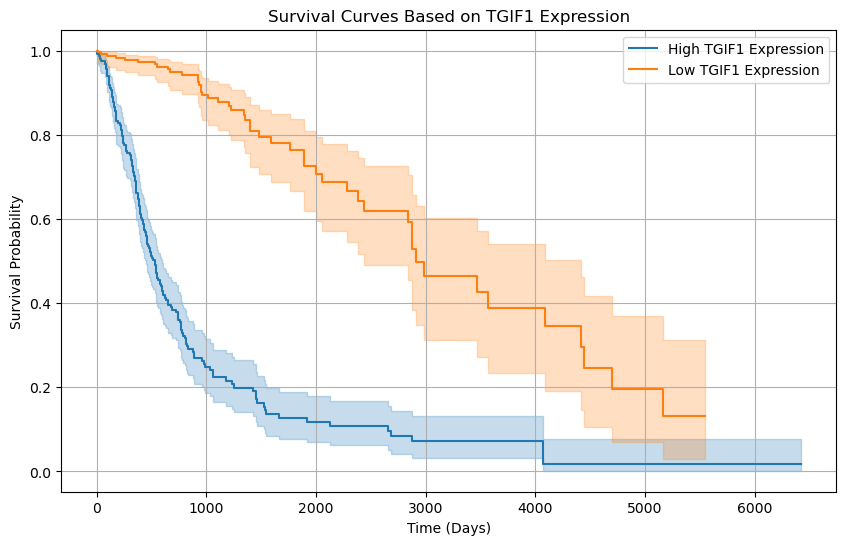

In [79]:
from lifelines import KaplanMeierFitter

# divide dataset into high and low expression based on median 
median_TGIF1 = reduced_biomarker_data_significant['TGIF1'].median()

# create two groups: high expression and low expression
high_TGIF1 = reduced_biomarker_data_significant[reduced_biomarker_data_significant['TGIF1'] > median_TGIF1]
low_TGIF1 = reduced_biomarker_data_significant[reduced_biomarker_data_significant['TGIF1'] <= median_TGIF1]

high_survival_info = survival_info.loc[high_TGIF1.index]
low_survival_info = survival_info.loc[low_TGIF1.index]

kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

# fit the Kaplan-Meier curves for the high and low TGIF1 groups
kmf_high.fit(high_survival_info['time'], event_observed=high_survival_info['event'], label='High TGIF1 Expression')
kmf_low.fit(low_survival_info['time'], event_observed=low_survival_info['event'], label='Low TGIF1 Expression')

plt.figure(figsize=(10, 6))
kmf_high.plot_survival_function()
kmf_low.plot_survival_function()

plt.title("Survival Curves Based on TGIF1 Expression")
plt.xlabel("Time (Days)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.show()

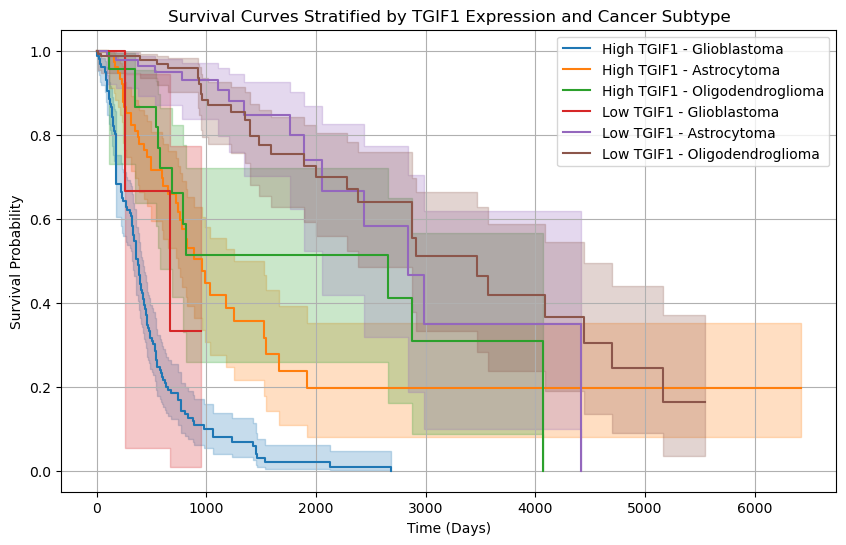

In [99]:
# subtype breakdown
for subtype in high_survival_info['cancer_type'].unique():
    subtype_mask = high_survival_info['cancer_type'] == subtype
    kmf_high.fit(high_survival_info.loc[subtype_mask]['time'], 
                 event_observed=high_survival_info.loc[subtype_mask]['event'], 
                 label=f'High TGIF1 - {subtype}')
    kmf_high.plot_survival_function()

for subtype in low_survival_info['cancer_type'].unique():
    subtype_mask = low_survival_info['cancer_type'] == subtype
    kmf_low.fit(low_survival_info.loc[subtype_mask]['time'], 
                event_observed=low_survival_info.loc[subtype_mask]['event'], 
                label=f'Low TGIF1 - {subtype}')
    kmf_low.plot_survival_function()

plt.title("Survival Curves Stratified by TGIF1 Expression and Cancer Subtype")
plt.xlabel("Time (Days)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.legend()
plt.show()

1. High TGIF1 Expression (blue, orange, green): The survival curves for patients with high TGIF1 expression vary across glioma subtypes.
2. Low TGIF1 Expression (red, purple, brown): Low TGIF1 expression shows a slower decline in survival probability for all subtypes. However, glioblastoma patients (red) with low TGIF1 expression still have poor outcomes compared to the other subtypes.

There appears to be a strong subtype-specific effect in survival that interacts with TGIF1 expression levels. This is especially evident in glioblastoma patients, where both high and low TGIF1 expression groups exhibit poor survival, but high TGIF1 expression corresponds with even worse outcomes in all subtypes.